In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Igor\AppData\Local\Temp\ipykernel_4920\37510669.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display as html_width


In [2]:
suffix_name="6_diff_trajects+3Btp_just_query" #used to save the network with different names among notebooks

### Generating a sample training distribution

These demonstrations are used in the first experiment of the __Conditional Neural Movement Primitives (RSS 2019) by Yunus Seker, Mert Imre, Justus Piater and Emre Ugur__

In __CNMP__, trajectories are defined as f(X) = Y where
  * __X__: includes time and task parameter information
  * __Y__: includes corresponding output (joint, endpoint, image, motor, etc.) for the given time and task parameters

This experiment does not involve external task parameters. 6 training and 4 validation trajectories are plotted below

training X  (6, 200, 4)
training Y  (6, 200, 1)
[[[0.         1.         0.         0.        ]
  [0.00502513 1.         0.         0.        ]
  [0.01005025 1.         0.         0.        ]
  ...
  [0.98994975 1.         0.         0.        ]
  [0.99497487 1.         0.         0.        ]
  [1.         1.         0.         0.        ]]

 [[0.         1.         0.         0.        ]
  [0.00502513 1.         0.         0.        ]
  [0.01005025 1.         0.         0.        ]
  ...
  [0.98994975 1.         0.         0.        ]
  [0.99497487 1.         0.         0.        ]
  [1.         1.         0.         0.        ]]

 [[0.         0.         1.         0.        ]
  [0.00502513 0.         1.         0.        ]
  [0.01005025 0.         1.         0.        ]
  ...
  [0.98994975 0.         1.         0.        ]
  [0.99497487 0.         1.         0.        ]
  [1.         0.         1.         0.        ]]

 [[0.         0.         1.         0.        ]
  [0.00502513 0.

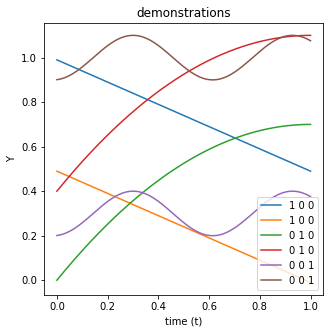

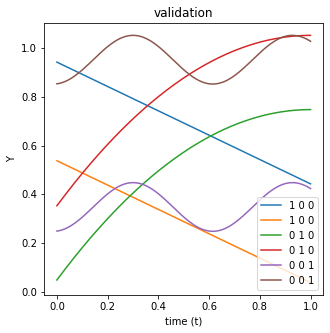

In [3]:
### you can use https://www.desmos.com/calculator to find the parameters of the desired curves below
def distribution_generator(x, param, noise=0):
    f = (exp(-x**2/(2.*param[0]**2))/(sqrt(2*math.pi)*param[0]))+param[1]
    return f+(noise*np.random.rand()/100.)

def line_generator(x, m,q, noise=0):
    return m*x+q +(noise*np.random.rand()/100.)

def parabolic_curve(x, a, b, c, noise=0):
    return a*x**2+b*x+c +(noise*np.random.rand()/100.)

def sin_generator(x, a, f, h=0, v=0, noise=0):
    return a*np.sin(f*(x-h))+v +(noise*np.random.rand()/100.)

def generate_demonstrations(time_steps, title = None):
    noise=0
    if title=="Validation Demonstrations":
        import random
        noise=random.uniform(0.0, 0.3)
    x = np.linspace(0,1,time_steps) #array of 200 elems between two numbers
    times = np.zeros((6,time_steps,4)) #array of (num_demonstrations) elems with 200 elems (time_steps) with 2 elem (dimensions: x and task-parameters)
    times[:, :, 0] = x #to all demonstration, to all 200 times, only in first position put the x 
    times[0, :, 1] = 1 #to first demonstration, to all 200 times in second dimension put the task-parameters
    times[1, :, 1] = 1
    times[2, :, 2] = 1
    times[3, :, 2] = 1
    times[4, :, 3] = 1
    times[5, :, 3] = 1
    values = np.zeros((6,time_steps,1)) #array of 3 (num_demonstrations) elems with 200 elems (time_steps)
    for i in range(time_steps): #for all times
        values[0,i] = line_generator(x=x[i],m=-0.5, q=0.99-noise)
        values[1,i] = line_generator(x=x[i],m=-0.5, q=0.49+noise)
        values[2,i] = parabolic_curve(x=x[i], a=-0.7, b=1.4, c=0.0+noise)
        values[3,i] = parabolic_curve(x=x[i], a=-0.7, b=1.4, c=0.4-noise)
        values[4,i] = sin_generator(x=x[i],a=0.1, f=10, h=1.4, v=0.3+noise)
        values[5,i] = sin_generator(x=x[i],a=0.1, f=10, h=1.4, v=1.0-noise)
    return times, values

time_steps=200
X, Y = generate_demonstrations(time_steps, title='Training Demonstrations')
v_X, v_Y = generate_demonstrations(time_steps, title='Validation Demonstrations')

print('training X ', X.shape)
print('training Y ',Y.shape)
print(X)
print('validation X ', v_X.shape)
print('validation Y ',v_Y.shape)
#plot demonstrations
fig = plt.figure(figsize=(5,5))
for d in range(X.shape[0]):
    plt.plot(X[d, :,0], Y[d],label="%d %d %d"%(X[d][0][1], X[d][0][2], X[d][0][3]) )
plt.title("demonstrations")
plt.ylabel('Y')
plt.xlabel('time (t)')
plt.legend()
plt.show()
#plot validation 
fig = plt.figure(figsize=(5,5))
for d in range(X.shape[0]):
    plt.plot(v_X[d, :,0], v_Y[d],label="%d %d %d"%(X[d][0][1], X[d][0][2], X[d][0][3]) )
plt.title("validation")
plt.ylabel('Y')
plt.xlabel('time (t)')
plt.legend()
plt.show()
#save
np.save('training_X',X)
np.save('training_Y',Y)
np.save('validation_X',v_X)
np.save('validation_Y',v_Y)

### Initialization

Input Requirements:

  * __obs_max__: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5

  * __d_N__: Number of demonstrations

  * __d_x__: X vector feature dim (*NOTE THAT*: task parameters are assumed to be inside of the X vector, concatenated to time value. This experiment does not use external parameters so d_x = 1)

  * __d_y__: Y vector feature dim (In this experiment the output of trajectories are 1D single values so d_y = 1)

  * __time_len__: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

  * __X__: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

  * __Y__: shape=(d_N,time_len,d_y) --- corresponding values of f(X) for ith demonstration

In [4]:
X, Y = (np.load('training_X.npy'), np.load('training_Y.npy'))
v_X, v_Y = (np.load('validation_X.npy'), np.load('validation_Y.npy'))
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 

print('d_N = %d'%d_N)
print('obs_max = %d'%obs_max)
print('X = %s'%(X.shape,))
print('Y = %s'%(Y.shape,))
print('d_x = %d'%d_x)
print('d_y = %d'%d_y)
print('time_len = %d'%time_len)

d_N = 6
obs_max = 5
X = (6, 200, 4)
Y = (6, 200, 1)
d_x = 4
d_y = 1
time_len = 200


# Conditional Neural Movement Primitives

### get_train_sample():

* Selects a random observation number __n__

* Selects a random demonstration id __d__

* Permutes demonstration __d__, so the first __n__ data can be sampled as __observations__. Selects __(n+1)th__ data to be the __target point__ that __CNMP__ will try to predict

* Returns:
  * __observations__: A batch that includes sampled observations
  * __target_X__: A batch that includes all target timesteps
  * __target_Y__: A batch that includes corresponding output for sampled __target_X__ timestep

__NOTICE__: In training, the size of the __target_X__ batch is set to __1__. But in test time, __any size__ of multiple timesteps can be queried as a batch. This allows __whole trajectory prediction at once__.

In [5]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    
    observations = np.zeros((n,d_x+d_y)) 
    target_X = np.zeros((1,d_x))
    target_Y = np.zeros((1,d_y))
    
    perm = np.random.permutation(time_len)
    observations[:n,:d_x] = X[d,perm[:n]]
    observations[:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0] = X[d,perm[n]]
    target_Y[0] = Y[d,perm[n]]
    return torch.from_numpy(np.delete(observations, [1,2,3], axis=1)), torch.from_numpy(target_X), torch.from_numpy(target_Y) #edit here to pass only the x observation without tp

observations=5
tensor([[0.6784, 0.1508],
        [0.9548, 0.0126],
        [0.3467, 0.3166],
        [0.4623, 0.2588],
        [0.5980, 0.1910]], dtype=torch.float64)
query x:
tensor([[0.1106, 1.0000, 0.0000, 0.0000]], dtype=torch.float64)
true y:
tensor([[0.4347]], dtype=torch.float64)


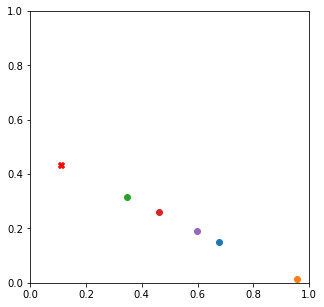

In [6]:
# example training sample
o,tx,ty = get_train_sample()
print("observations="+str(len(o)))
print(o)
print("query x:")
print(tx)
print("true y:")
print(ty)
fig = plt.figure(figsize=(5,5))
for j in range(len(o)):
    plt.scatter(o[j][0].item(),o[j][-1].item())
plt.scatter(tx[0][0],ty,marker="X",color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show() 

### predict_model(observations, target_X, plot):
Predicts outputs according to the given __observations__ and __target_X batch__.

* __observations__: Batch of observations. Dimensions = (obs_n, d_x+d_y) where __obs_n__ is the number of observations will ve used for this prediction
* __target_X__: Batch of time points to be predicted. Dimension = (target_n, d_x) where __target_n__ is the number of points to predict

*For whole trajectory prediction give all X points through time length as a batch (for ex. the first demonstration = X[0])*

* __prediction__: Predicted __means__ and __standart deviations__ for each time point in the X. Later splitted into __predicted_Y__ and __predicted_std__
* __plot__: if __True__, plots demonstrations and predicted distribution

In [7]:
def predict_model(observations, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_X)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # plot training data assuming X[j,:,0] is time
            #plt.plot(X[j,:,0],predicted_Y[:,i],marker="o",color='red')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observations[:,0],observations[:,-1],marker="X",color='black') #edit here to pass only x without tp
            plt.show()  
    return predicted_Y, predicted_std

### custom_loss(output, target):

Calculates __log probability__ of the true value of the target point according to the __multivariate Gaussian__ constructed by __predicted means__ and __stds__

Returns minus of that value

In [8]:
def log_prob_loss(output, target):
    mean, sigma = output.chunk(2, dim = -1)
    sigma = F.softplus(sigma)
    dist = D.Independent(D.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

### CNMP Module

* __encoder__: Observation encoder module that takes a batch of __observations__ and converts each of them to their latent space representations

* __decoder__: Decoder module that takes the batch of __r_mean__ and __target_t__ tuples and produces mean and std values for each dimension of the output

*NOTICE: __Observation encoding__ is a __parallelized operation__ which __none__ of the inputs are dependent on each other and __none__ of the outputs are affected by the values of others in the batch*

In [9]:
class CNMP(nn.Module):
    
    def __init__(self):
        super(CNMP, self).__init__()
        
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(d_x-3+d_y,128),nn.ReLU(), #edit here to pass only x without tp
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(128+d_x,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,2*d_y)
        )
        
    def forward(self,observations,target_t):
        r = self.encoder(observations) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(target_t.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,target_t),dim=-1) # Concatenating each target_t with general representation
        output = self.decoder(concat) # Producing mean and std values for each target_t
        return output

### Initializing the model

In [10]:
model = CNMP().double()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the CNMP

<Figure size 640x480 with 0 Axes>

990000


<Figure size 640x480 with 0 Axes>

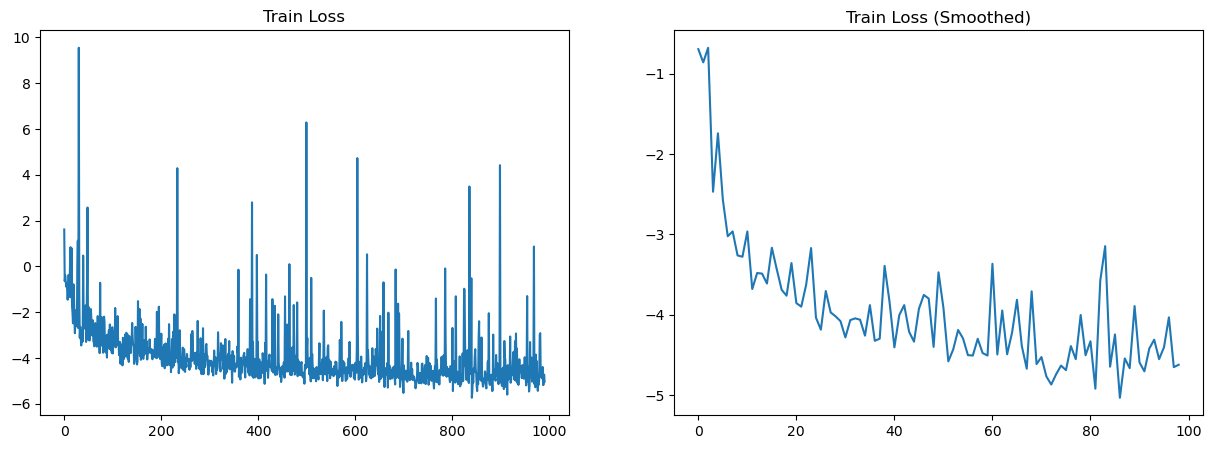

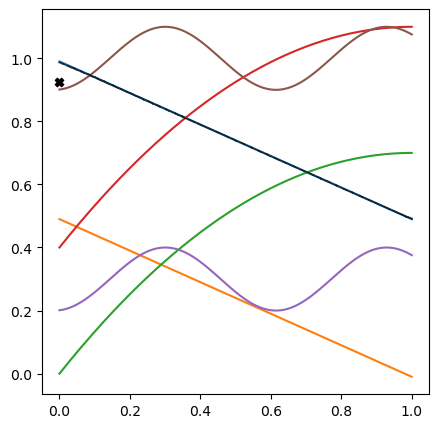

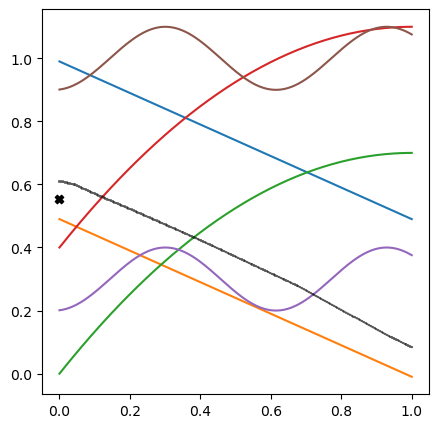

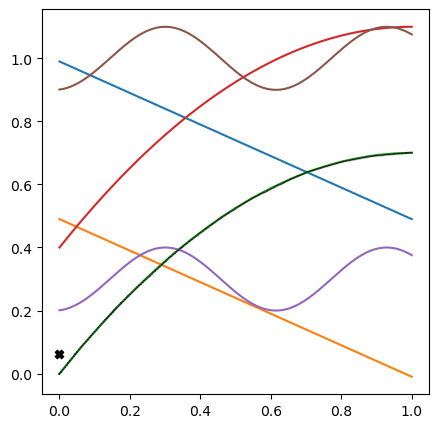

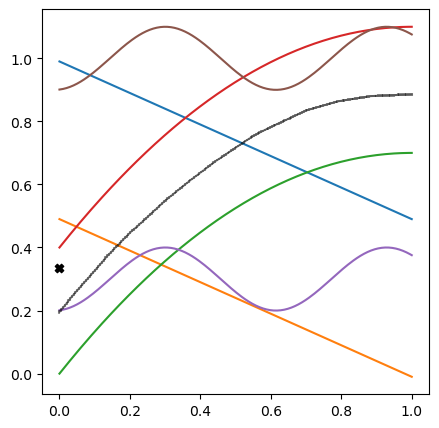

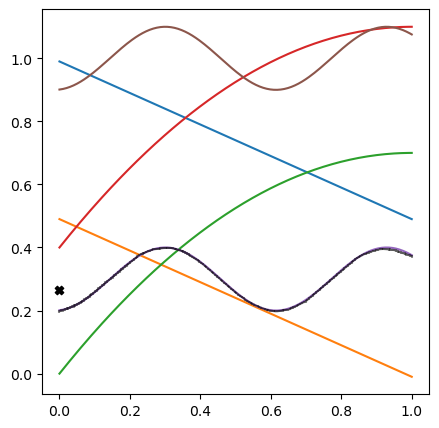

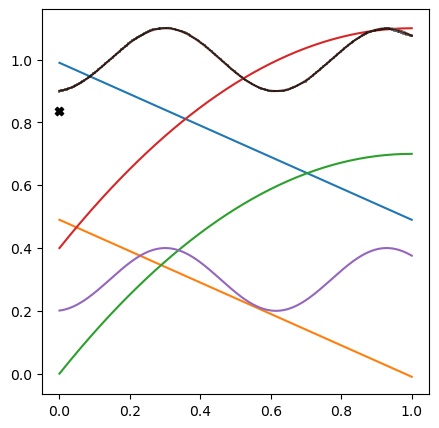

Finished Training


In [10]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
plot_checkpoint = 10000
validation_checkpoint = 100
validation_error = 9999999

for step in range(1000000):  # loop over the dataset multiple times
    observations, target_t, target_output = get_train_sample()
    
    optimizer.zero_grad()

    output = model(observations, target_t)
    loss = log_prob_loss(output, target_output)
    loss.backward()
    optimizer.step()
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data)
        smooth_losses[-1] += loss.data/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        current_error = 0
        for i in range(v_X.shape[0]):
            predicted_Y,predicted_std = predict_model(np.array([np.concatenate((np.delete(v_X[i,0], [1,2,3], axis=0),v_Y[i,0]))]), v_X[i], plot= False) #edit here to pass only with first element and not tp
            current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), 'cnmp_best_validation'+suffix_name+'.h5')
            print(' New validation best. Error is ', current_error)
        
    if step % plot_checkpoint == 0:
        #clearing output cell
        display.clear_output(wait=True)
        display.display(pl.gcf())
        
        print(step)
        #plotting training examples and smoothed losses
        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)),smooth_losses)
        plt.show()
        
        #plotting validation cases
        for i in range(v_X.shape[0]):
            predict_model(np.array([np.concatenate((np.delete(v_X[i,0], [1,2,3], axis=0),v_Y[i,0]))]), v_X[i]) #edit here to pass v_X only with first element and not tp
        
        if step!=0:
            smooth_losses.append(0)
print('Finished Training')
torch.save(model.state_dict(), 'cnmp_best_validation'+suffix_name+'LAST.h5')

### Loading Best Model

In [11]:
model = CNMP().double()
model.load_state_dict(torch.load('cnmp_best_validation'+suffix_name+'.h5'))
model.eval()

CNMP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=132, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

### Testing the Model

#### Normal prediction

In [12]:
time_queries_1=X[0]
time_queries_2=X[2]
time_queries_3=X[4]

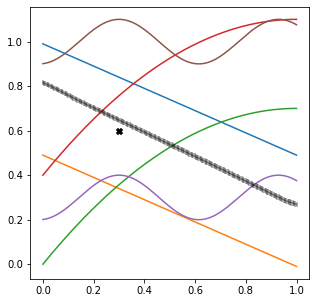

In [16]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.3],[0.6]))]), target_X=time_queries_1)

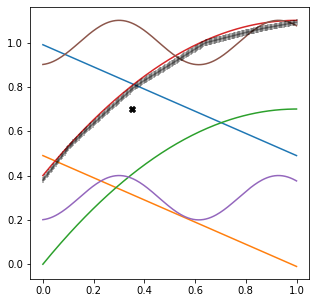

In [17]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.35],[0.7]))]), target_X=time_queries_2)

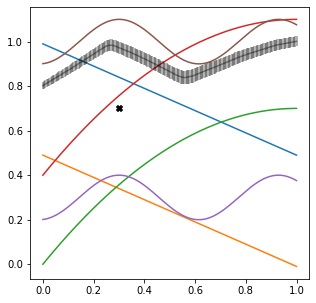

In [18]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.30],[0.7]))]), target_X=time_queries_3)

#### More observations

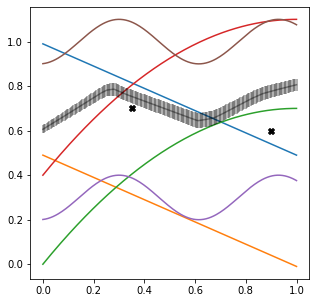

In [19]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.35],[0.7])),np.concatenate(([0.9],[0.6]))]), target_X=time_queries_3)

## OUT OF BOUNDS TEST

In [20]:
def predict_model_free(observations, target_Xs, plot = True):
    predicted_Y = np.zeros((target_Xs.shape[0],d_y)) #number of Xs of dimension of Y elems
    predicted_std = np.zeros((target_Xs.shape[0],d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_Xs)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: 
        for i in range(d_y): #for every dimension in Y vector we are plotting training data and prediction
            fig = plt.figure(figsize=(8,8))
            for dem in range(d_N): #for all demonstration
                plt.plot(X[dem,:,0],Y[dem,:,i]) # plot training data
            plt.scatter(observations[:,0],observations[:,-1],marker="X",color='black') #plot observations
            #plot preditions
            #plt.plot(target_Xs,predicted_Y[:,i],marker="X",color='red',markersize=2)
            plt.errorbar(target_Xs[:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.show()  
    return predicted_Y, predicted_std

In [21]:
lol = np.linspace(-1,2,200) # 200 elems from to 
pred_range = np.zeros((200,4))
pred_range[:, 0] = lol #now each of the 200 elems has an elem that has the time 
pred_range[:,1] = 1 # to all 200 times in second dimension put the first goal
#pred_range
print(pred_range.shape)
print("should match")
print(X[0].shape)


(200, 4)
should match
(200, 4)


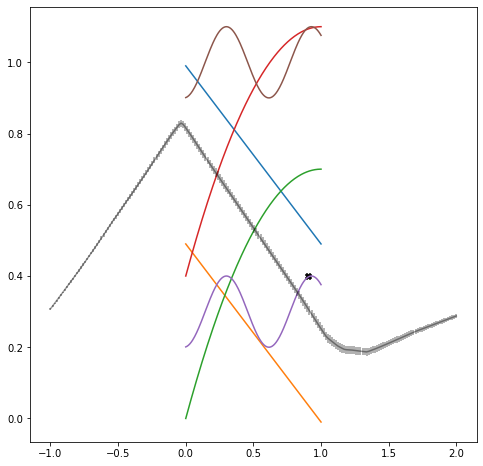

In [22]:
#RUN THE MODEL PREDICTIONS UNBOUNDED
pred_range[:,1] = 1 # to all 200 times in second dimension put the task param
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.9],[0.4]))]), pred_range)

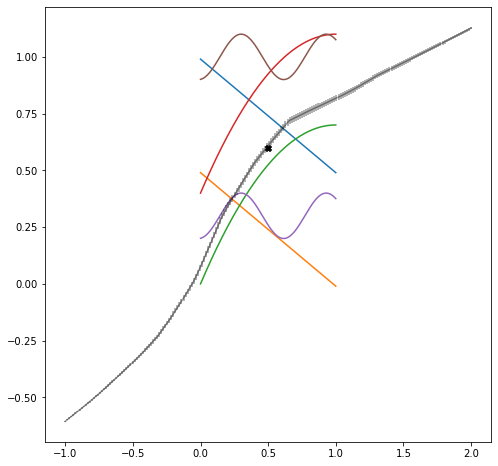

In [23]:
pred_range[:,1] = 0 # to all 200 times in second dimension put the task param
pred_range[:,2] = 1 # to all 200 times in second dimension put the task param
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.5],[0.6]))]), pred_range)

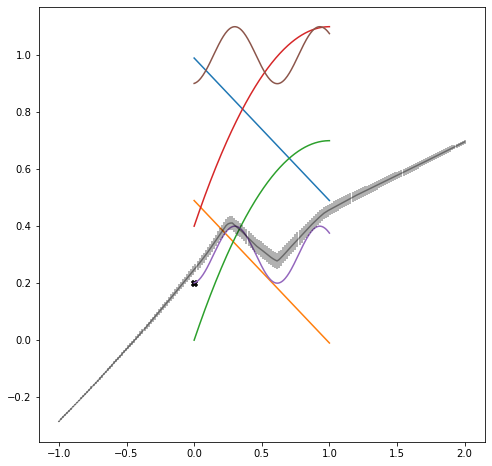

In [24]:
pred_range[:,1] = 0 # to all 200 times in second dimension put the task param
pred_range[:,2] = 0 # to all 200 times in second dimension put the task param
pred_range[:,3] = 1 # to all 200 times in second dimension put the task param
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.0],[0.2]))]), pred_range)

## 3D Plot

In [25]:
num_tp_samples=17
all_tp = np.zeros((num_tp_samples,3))
all_tp[:,0] = np.linspace(0,num_tp_samples-1,num_tp_samples) #indexes in first place
all_tp[:,1] = np.linspace(0,1,num_tp_samples) #tps in second place from 0 to 1
all_tp[:,2] = np.linspace(1,0,num_tp_samples) #tps in second place from 1 to 0
tp_inc_value_array = all_tp[:,1] #array of task parameters only
tp_dec_value_array = all_tp[:,2] #array of task parameters only
print(all_tp)
# index   task parameter

[[ 0.      0.      1.    ]
 [ 1.      0.0625  0.9375]
 [ 2.      0.125   0.875 ]
 [ 3.      0.1875  0.8125]
 [ 4.      0.25    0.75  ]
 [ 5.      0.3125  0.6875]
 [ 6.      0.375   0.625 ]
 [ 7.      0.4375  0.5625]
 [ 8.      0.5     0.5   ]
 [ 9.      0.5625  0.4375]
 [10.      0.625   0.375 ]
 [11.      0.6875  0.3125]
 [12.      0.75    0.25  ]
 [13.      0.8125  0.1875]
 [14.      0.875   0.125 ]
 [15.      0.9375  0.0625]
 [16.      1.      0.    ]]


In [26]:
num_time_samples=200
time_queries = np.zeros((num_time_samples,4)) # dimensions (time and tps)
time_queries[:,0] = np.linspace(0,1,num_time_samples) #times in first place
print(time_queries)
#time        task parameter

[[0.         0.         0.         0.        ]
 [0.00502513 0.         0.         0.        ]
 [0.01005025 0.         0.         0.        ]
 [0.01507538 0.         0.         0.        ]
 [0.0201005  0.         0.         0.        ]
 [0.02512563 0.         0.         0.        ]
 [0.03015075 0.         0.         0.        ]
 [0.03517588 0.         0.         0.        ]
 [0.04020101 0.         0.         0.        ]
 [0.04522613 0.         0.         0.        ]
 [0.05025126 0.         0.         0.        ]
 [0.05527638 0.         0.         0.        ]
 [0.06030151 0.         0.         0.        ]
 [0.06532663 0.         0.         0.        ]
 [0.07035176 0.         0.         0.        ]
 [0.07537688 0.         0.         0.        ]
 [0.08040201 0.         0.         0.        ]
 [0.08542714 0.         0.         0.        ]
 [0.09045226 0.         0.         0.        ]
 [0.09547739 0.         0.         0.        ]
 [0.10050251 0.         0.         0.        ]
 [0.10552764 

In [27]:
graph = np.zeros((num_tp_samples,num_time_samples,3)) #for every task parameter, for every time queries contains data
graph[:,:,0]=time_queries[:,0] #first position times
repeated_tp_value_array=np.tile(tp_inc_value_array, (num_time_samples,1)) # many times the tp array
graph[:,:,1]=repeated_tp_value_array.T #second position task parameter
print(graph.shape)
print(graph)

(17, 200, 3)
[[[0.         0.         0.        ]
  [0.00502513 0.         0.        ]
  [0.01005025 0.         0.        ]
  ...
  [0.98994975 0.         0.        ]
  [0.99497487 0.         0.        ]
  [1.         0.         0.        ]]

 [[0.         0.0625     0.        ]
  [0.00502513 0.0625     0.        ]
  [0.01005025 0.0625     0.        ]
  ...
  [0.98994975 0.0625     0.        ]
  [0.99497487 0.0625     0.        ]
  [1.         0.0625     0.        ]]

 [[0.         0.125      0.        ]
  [0.00502513 0.125      0.        ]
  [0.01005025 0.125      0.        ]
  ...
  [0.98994975 0.125      0.        ]
  [0.99497487 0.125      0.        ]
  [1.         0.125      0.        ]]

 ...

 [[0.         0.875      0.        ]
  [0.00502513 0.875      0.        ]
  [0.01005025 0.875      0.        ]
  ...
  [0.98994975 0.875      0.        ]
  [0.99497487 0.875      0.        ]
  [1.         0.875      0.        ]]

 [[0.         0.9375     0.        ]
  [0.00502513 0.9375    

In [28]:
print(all_tp)

[[ 0.      0.      1.    ]
 [ 1.      0.0625  0.9375]
 [ 2.      0.125   0.875 ]
 [ 3.      0.1875  0.8125]
 [ 4.      0.25    0.75  ]
 [ 5.      0.3125  0.6875]
 [ 6.      0.375   0.625 ]
 [ 7.      0.4375  0.5625]
 [ 8.      0.5     0.5   ]
 [ 9.      0.5625  0.4375]
 [10.      0.625   0.375 ]
 [11.      0.6875  0.3125]
 [12.      0.75    0.25  ]
 [13.      0.8125  0.1875]
 [14.      0.875   0.125 ]
 [15.      0.9375  0.0625]
 [16.      1.      0.    ]]


tp ratio: 0.000 1.000 
queries from [0. 1. 0. 0.] .. [1. 1. 0. 0.]


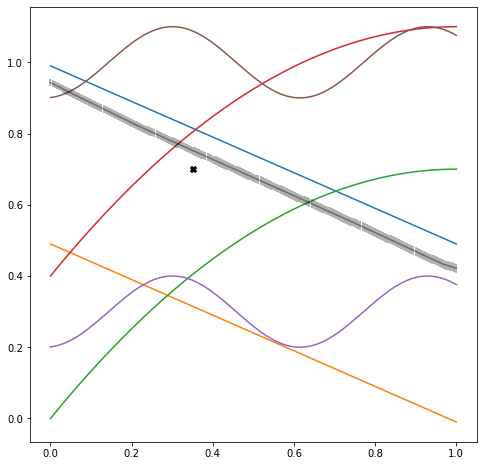

tp ratio: 0.062 0.938 
queries from [0.     0.9375 0.0625 0.    ] .. [1.     0.9375 0.0625 0.    ]


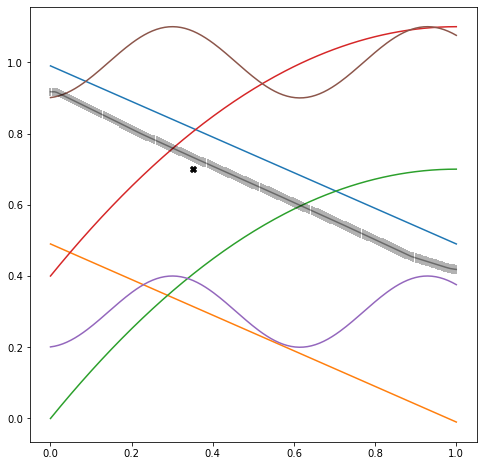

tp ratio: 0.125 0.875 
queries from [0.    0.875 0.125 0.   ] .. [1.    0.875 0.125 0.   ]


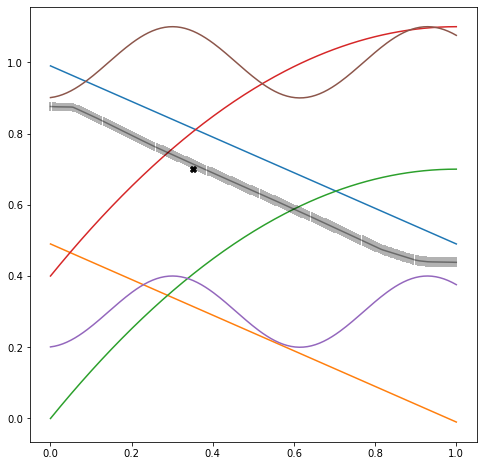

tp ratio: 0.188 0.812 
queries from [0.     0.8125 0.1875 0.    ] .. [1.     0.8125 0.1875 0.    ]


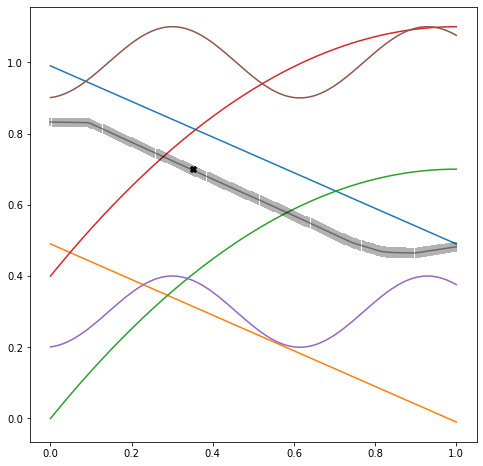

tp ratio: 0.250 0.750 
queries from [0.   0.75 0.25 0.  ] .. [1.   0.75 0.25 0.  ]


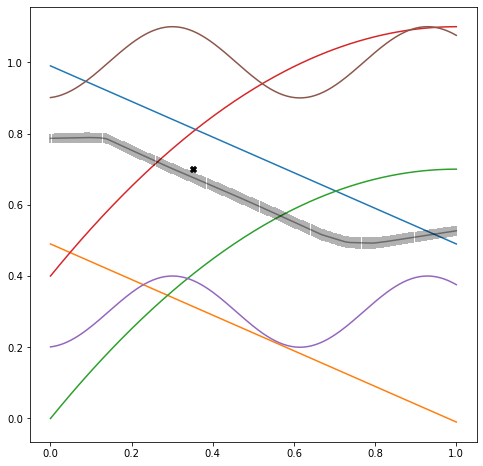

tp ratio: 0.312 0.688 
queries from [0.     0.6875 0.3125 0.    ] .. [1.     0.6875 0.3125 0.    ]


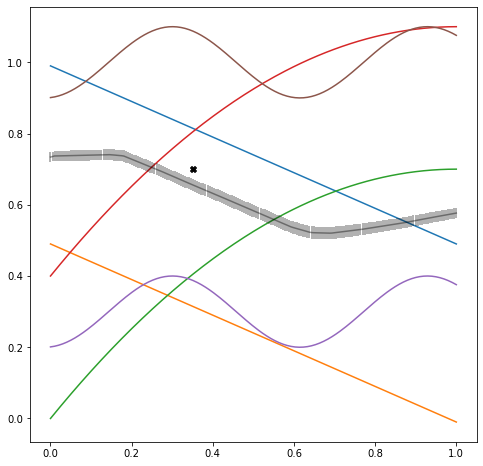

tp ratio: 0.375 0.625 
queries from [0.    0.625 0.375 0.   ] .. [1.    0.625 0.375 0.   ]


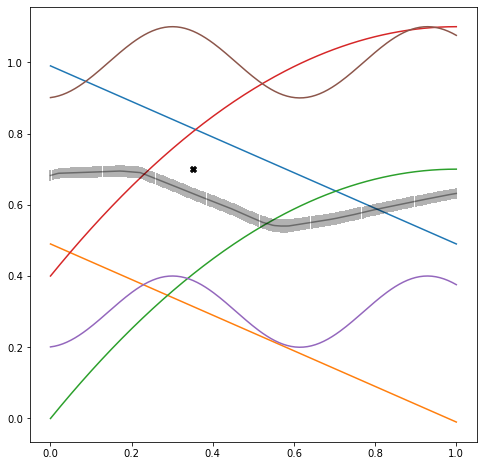

tp ratio: 0.438 0.562 
queries from [0.     0.5625 0.4375 0.    ] .. [1.     0.5625 0.4375 0.    ]


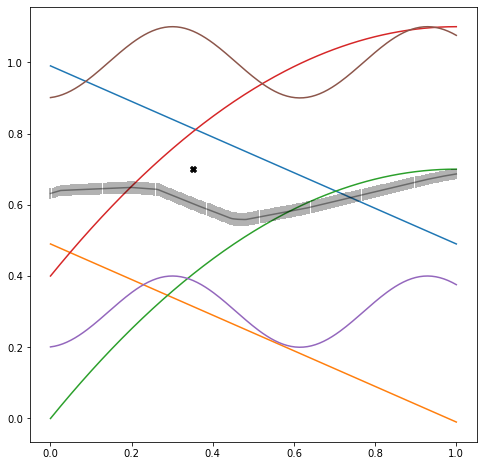

tp ratio: 0.500 0.500 
queries from [0.  0.5 0.5 0. ] .. [1.  0.5 0.5 0. ]


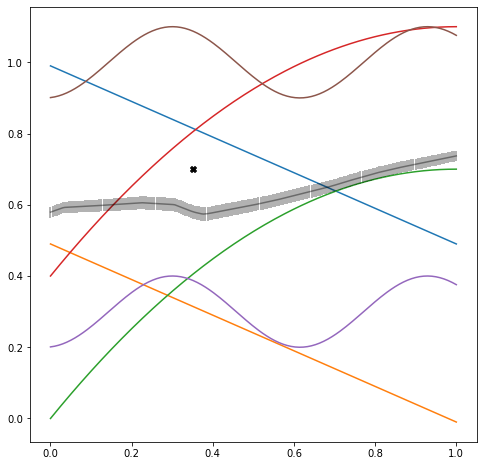

tp ratio: 0.562 0.438 
queries from [0.     0.4375 0.5625 0.    ] .. [1.     0.4375 0.5625 0.    ]


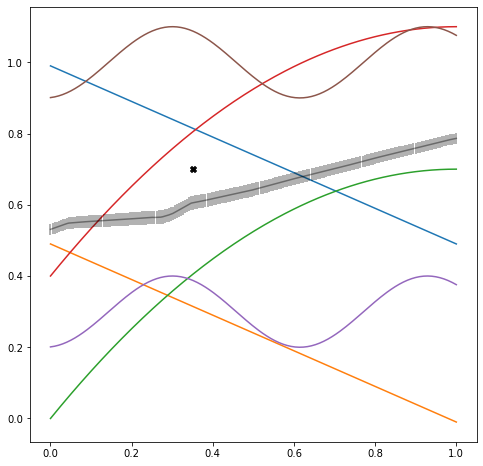

tp ratio: 0.625 0.375 
queries from [0.    0.375 0.625 0.   ] .. [1.    0.375 0.625 0.   ]


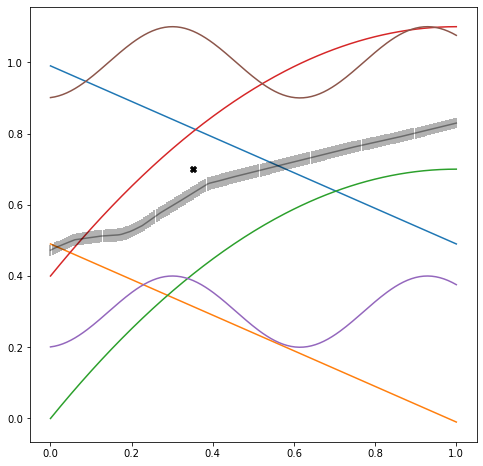

tp ratio: 0.688 0.312 
queries from [0.     0.3125 0.6875 0.    ] .. [1.     0.3125 0.6875 0.    ]


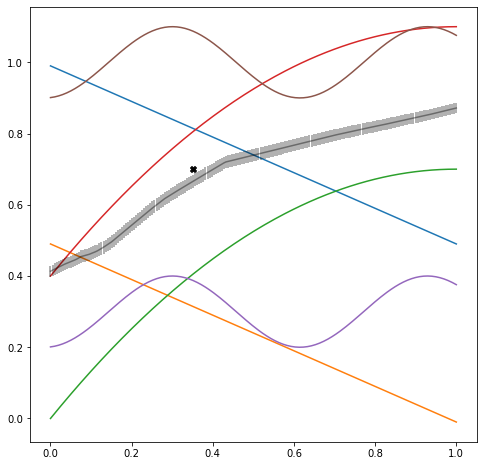

tp ratio: 0.750 0.250 
queries from [0.   0.25 0.75 0.  ] .. [1.   0.25 0.75 0.  ]


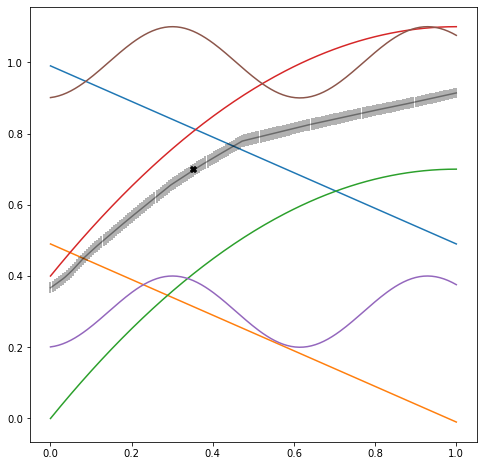

tp ratio: 0.812 0.188 
queries from [0.     0.1875 0.8125 0.    ] .. [1.     0.1875 0.8125 0.    ]


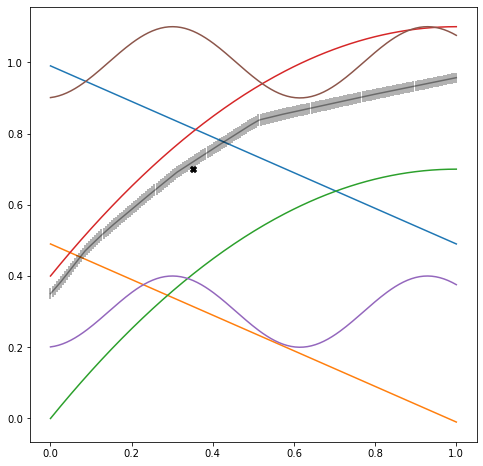

tp ratio: 0.875 0.125 
queries from [0.    0.125 0.875 0.   ] .. [1.    0.125 0.875 0.   ]


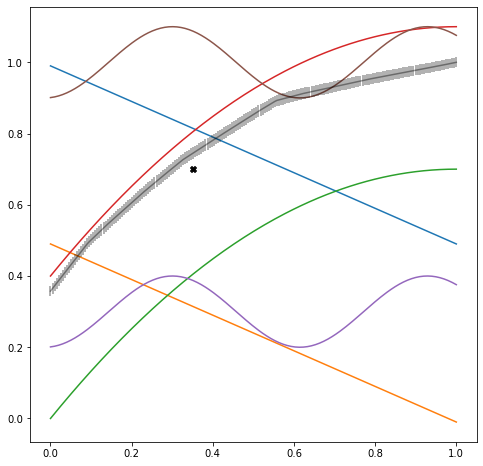

tp ratio: 0.938 0.062 
queries from [0.     0.0625 0.9375 0.    ] .. [1.     0.0625 0.9375 0.    ]


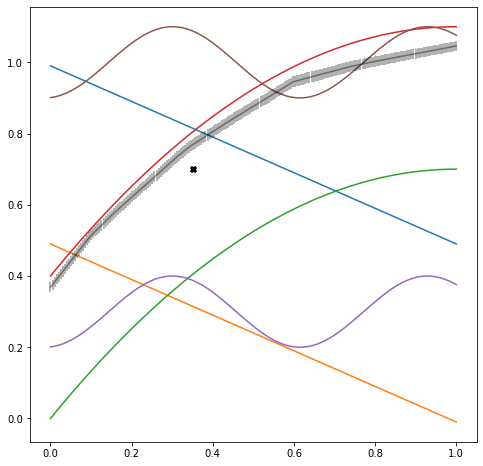

tp ratio: 1.000 0.000 
queries from [0. 0. 1. 0.] .. [1. 0. 1. 0.]


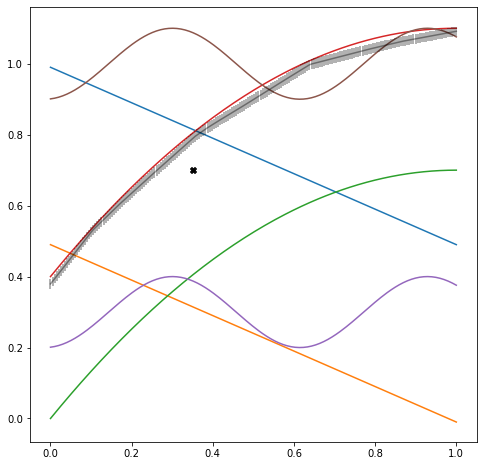

In [63]:
for curr_tp in all_tp:
    curr_tp_index,curr_tp_inc_value,curr_tp_dec_value = curr_tp[0],curr_tp[1],curr_tp[2]
    print("tp ratio: %.3f %.3f "%(curr_tp_inc_value,curr_tp_dec_value))
    time_queries[:,1]=curr_tp_dec_value
    time_queries[:,2]=curr_tp_inc_value
    time_queries[:,3]=0
    print("queries from "+str(time_queries[0])+" .. "+str(time_queries[199]))
    predicted_Ys,predicted_std=predict_model_free(np.array([np.concatenate(([0.35],[0.7]))]),time_queries)
    graph[int(curr_tp_index),:,2]=predicted_Ys.reshape(200) #from 200,1 to 200 #third position value

In [64]:
print(graph)

[[[0.         0.         0.94279208]
  [0.00502513 0.         0.94004508]
  [0.01005025 0.         0.93729807]
  ...
  [0.98994975 0.         0.42536418]
  [0.99497487 0.         0.42349395]
  [1.         0.         0.42162373]]

 [[0.         0.0625     0.91728539]
  [0.00502513 0.0625     0.91722749]
  [0.01005025 0.0625     0.9171696 ]
  ...
  [0.98994975 0.0625     0.42002143]
  [0.99497487 0.0625     0.4191486 ]
  [1.         0.0625     0.41845866]]

 [[0.         0.125      0.87591276]
  [0.00502513 0.125      0.87575607]
  [0.01005025 0.125      0.87534181]
  ...
  [0.98994975 0.125      0.43864289]
  [0.99497487 0.125      0.43849161]
  [1.         0.125      0.43833906]]

 ...

 [[0.         0.875      0.35765605]
  [0.00502513 0.875      0.36501292]
  [0.01005025 0.875      0.37236979]
  ...
  [0.98994975 0.875      0.99765169]
  [0.99497487 0.875      0.99882781]
  [1.         0.875      1.00000339]]

 [[0.         0.9375     0.36861889]
  [0.00502513 0.9375     0.37595393]


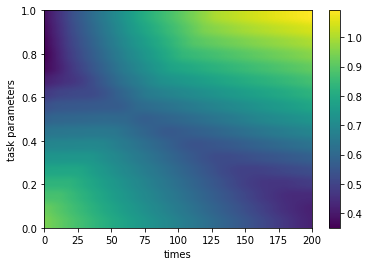

In [65]:
reshaped_data = graph[:,:,2] #taking only the predictions in 2D
reshaped_data=np.flip(reshaped_data, axis=0)
# Create a heatmap plot
plt.imshow(reshaped_data,extent=[0, num_time_samples, 0, 1], cmap='viridis', aspect='auto')

# Add colorbar
plt.colorbar()

# Set labels for the axes
plt.xlabel('times')
plt.ylabel('task parameters')

# Show the plot
plt.show()

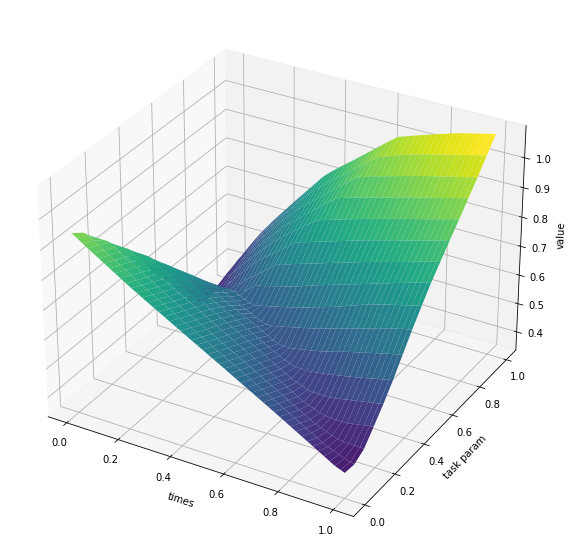

In [66]:
from mpl_toolkits import mplot3d

z = graph[:, :,2] #z values are in the 3rd dimension of graph
#print(z.shape)
z=z.T #transpose
#print(z.shape)

# Create a meshgrid from x and y values
TPs, TIMEs = np.meshgrid(tp_inc_value_array, time_queries[:,0]) #repeats x array as many times as y and y array as many times as x

# Create a 3D axes object
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D surface plot
ax.plot_surface(TIMEs, TPs, z, cmap='viridis')
#or simply
#ax.plot_surface(graph[:,:,0], graph[:,:,1], graph[:, :,2], cmap='viridis')

# Set labels for the axes
ax.set_xlabel('times')
ax.set_ylabel('task param')
ax.set_zlabel('value')

# Show the plot 
plt.show()

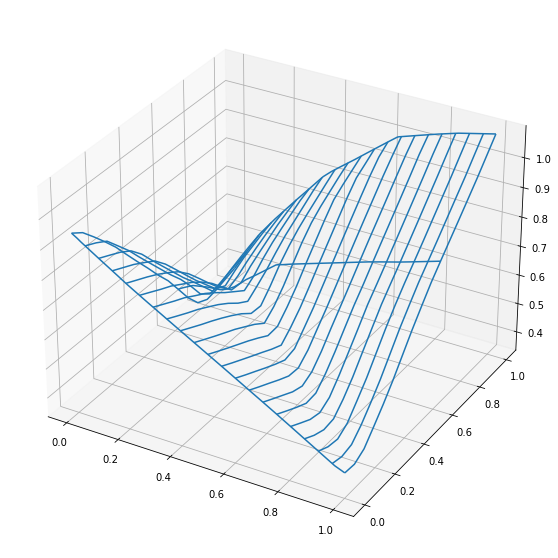

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


# Plot a basic wireframe.
ax.plot_wireframe(graph[:,:,0], graph[:,:,1], graph[:, :,2], rstride=10, cstride=10)

plt.show()

# Concatenation

In [34]:
time_queries=X[0].copy()

max_depth=2
start=0.5
params_array=[[1,0,0],[0,1,0],[0,0,1]]


In [35]:
num_traj=len(params_array)**(max_depth+1)
print("total trajectories number")
print(num_traj)
lengh_time=time_steps*(max_depth+1)
full_graph = np.zeros((0,lengh_time)) #array with  (time_steps) * max_depth
full_graph.shape

total trajectories number
27


(0, 600)

Depth 0
Starting from 0.50


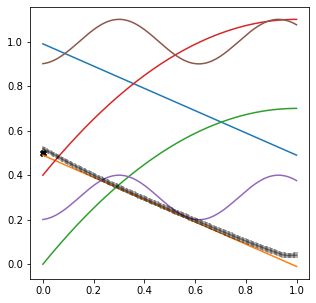

0.52 to 0.04
filling form 0 to 200
-Depth 1
Starting from 0.04


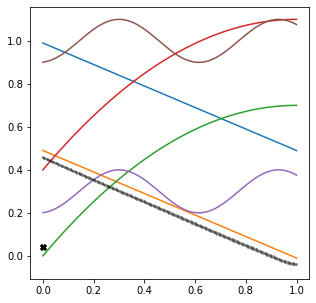

0.46 to -0.04
filling form 200 to 400
--Depth 2
Starting from -0.04


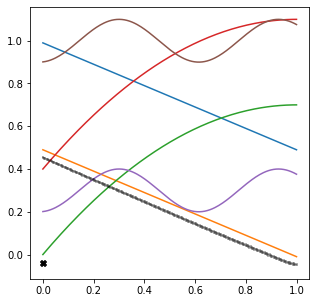

0.45 to -0.05
filling form 400 to 600
--Depth 2
Starting from -0.04


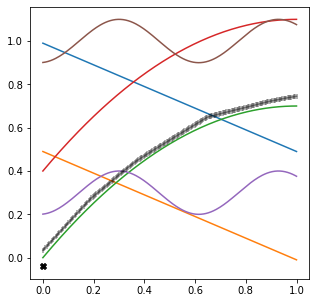

0.03 to 0.74
filling form 400 to 600
--Depth 2
Starting from -0.04


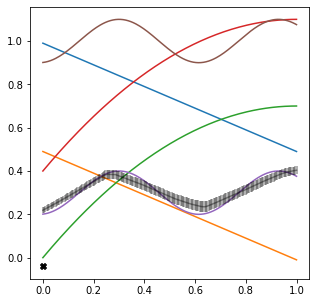

0.22 to 0.40
filling form 400 to 600
-Depth 1
Starting from 0.04


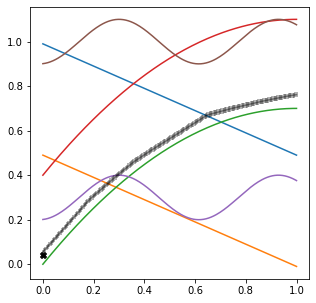

0.05 to 0.76
filling form 200 to 400
--Depth 2
Starting from 0.76


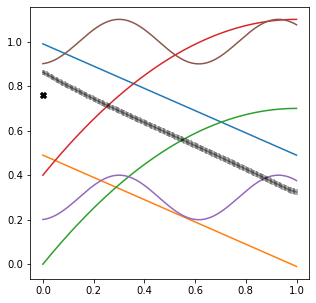

0.86 to 0.32
filling form 400 to 600
--Depth 2
Starting from 0.76


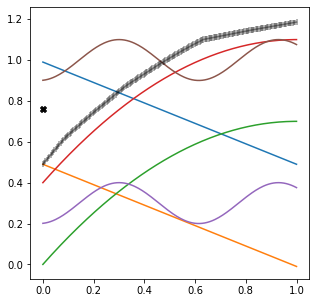

0.49 to 1.19
filling form 400 to 600
--Depth 2
Starting from 0.76


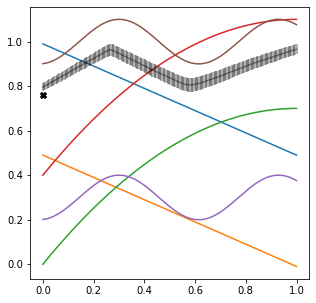

0.80 to 0.97
filling form 400 to 600
-Depth 1
Starting from 0.04


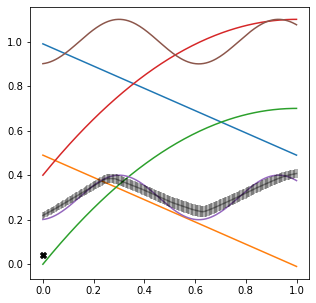

0.22 to 0.41
filling form 200 to 400
--Depth 2
Starting from 0.41


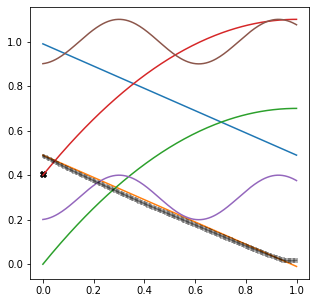

0.49 to 0.02
filling form 400 to 600
--Depth 2
Starting from 0.41


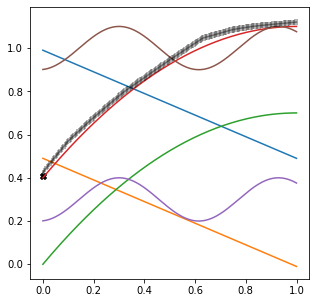

0.42 to 1.12
filling form 400 to 600
--Depth 2
Starting from 0.41


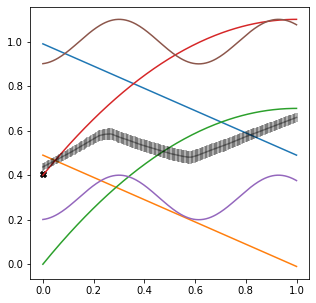

0.44 to 0.66
filling form 400 to 600
Depth 0
Starting from 0.50


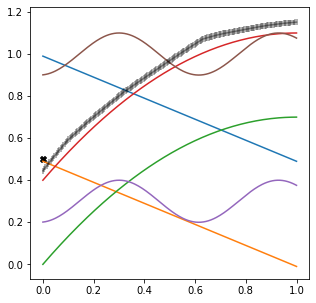

0.44 to 1.15
filling form 0 to 200
-Depth 1
Starting from 1.15


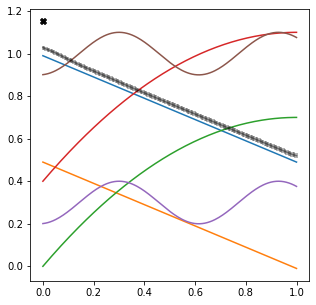

1.03 to 0.52
filling form 200 to 400
--Depth 2
Starting from 0.52


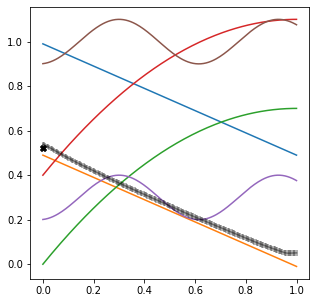

0.54 to 0.05
filling form 400 to 600
--Depth 2
Starting from 0.52


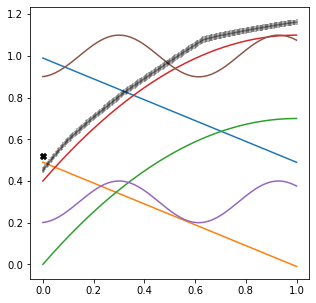

0.45 to 1.16
filling form 400 to 600
--Depth 2
Starting from 0.52


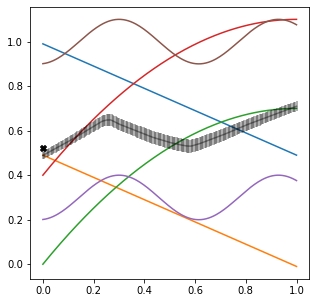

0.49 to 0.71
filling form 400 to 600
-Depth 1
Starting from 1.15


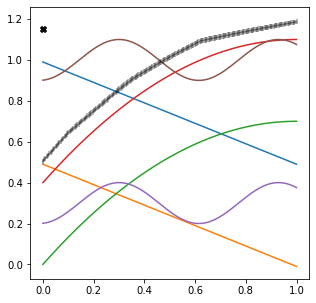

0.50 to 1.19
filling form 200 to 400
--Depth 2
Starting from 1.19


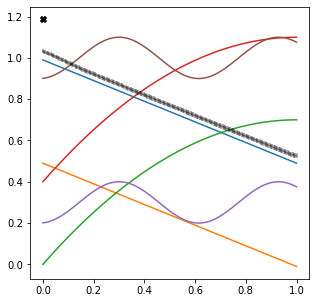

1.03 to 0.53
filling form 400 to 600
--Depth 2
Starting from 1.19


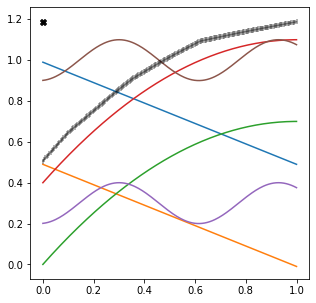

0.51 to 1.19
filling form 400 to 600
--Depth 2
Starting from 1.19


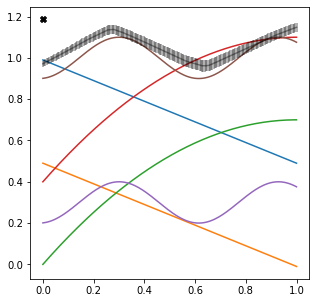

0.97 to 1.15
filling form 400 to 600
-Depth 1
Starting from 1.15


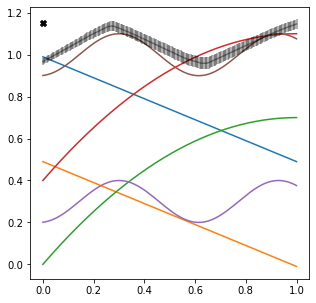

0.97 to 1.15
filling form 200 to 400
--Depth 2
Starting from 1.15


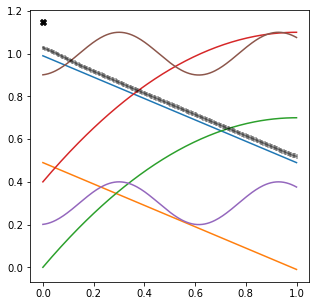

1.03 to 0.52
filling form 400 to 600
--Depth 2
Starting from 1.15


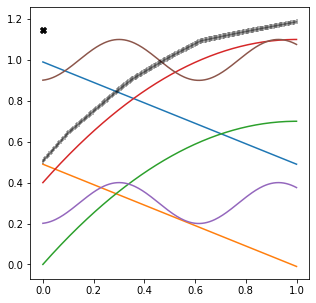

0.50 to 1.19
filling form 400 to 600
--Depth 2
Starting from 1.15


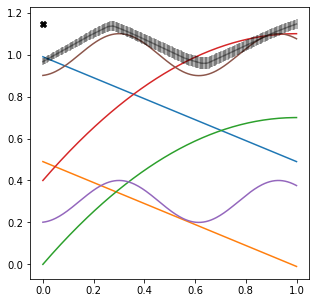

0.97 to 1.15
filling form 400 to 600
Depth 0
Starting from 0.50


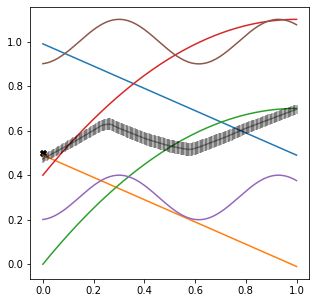

0.47 to 0.70
filling form 0 to 200
-Depth 1
Starting from 0.70


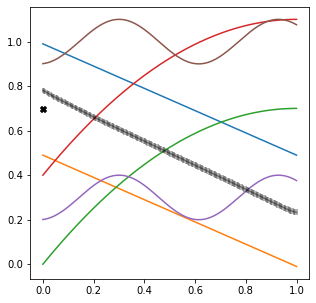

0.78 to 0.23
filling form 200 to 400
--Depth 2
Starting from 0.23


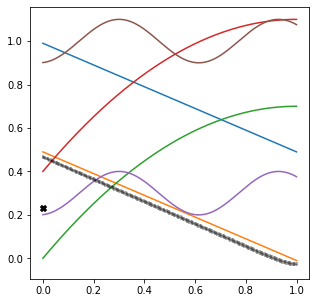

0.47 to -0.03
filling form 400 to 600
--Depth 2
Starting from 0.23


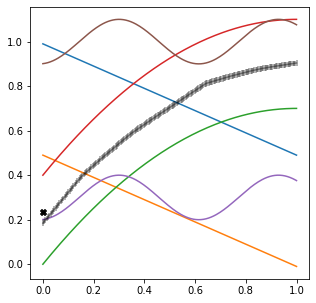

0.18 to 0.90
filling form 400 to 600
--Depth 2
Starting from 0.23


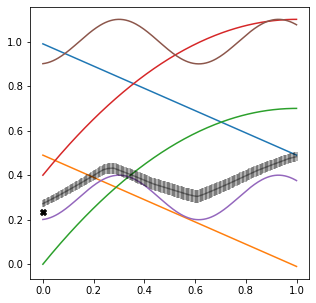

0.27 to 0.48
filling form 400 to 600
-Depth 1
Starting from 0.70


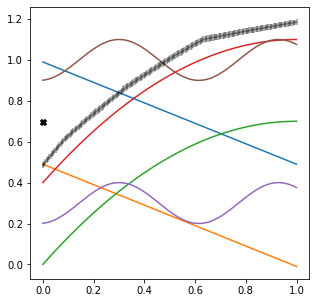

0.48 to 1.18
filling form 200 to 400
--Depth 2
Starting from 1.18


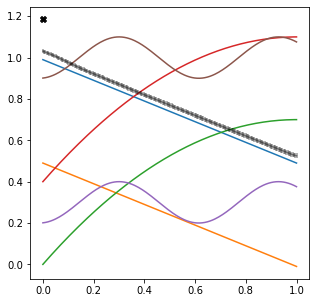

1.03 to 0.53
filling form 400 to 600
--Depth 2
Starting from 1.18


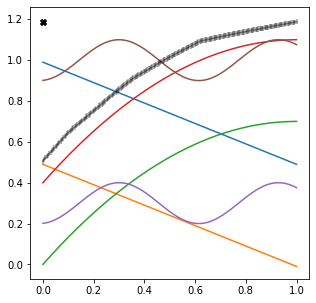

0.51 to 1.19
filling form 400 to 600
--Depth 2
Starting from 1.18


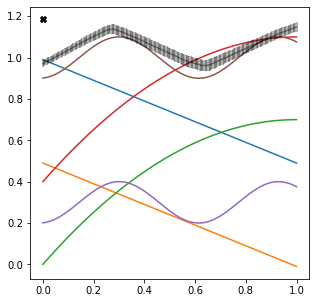

0.97 to 1.15
filling form 400 to 600
-Depth 1
Starting from 0.70


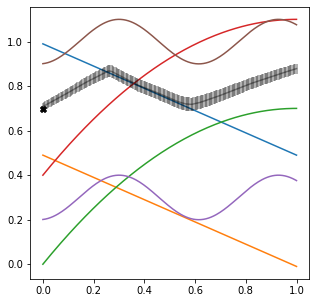

0.71 to 0.88
filling form 200 to 400
--Depth 2
Starting from 0.88


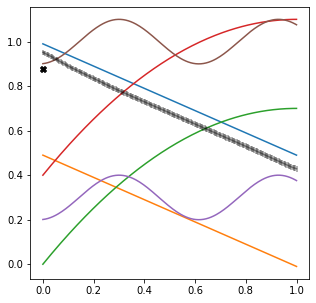

0.95 to 0.43
filling form 400 to 600
--Depth 2
Starting from 0.88


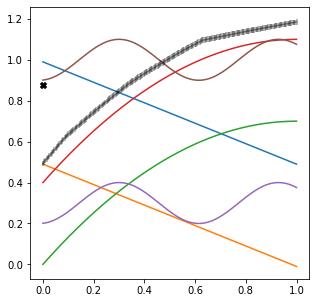

0.49 to 1.18
filling form 400 to 600
--Depth 2
Starting from 0.88


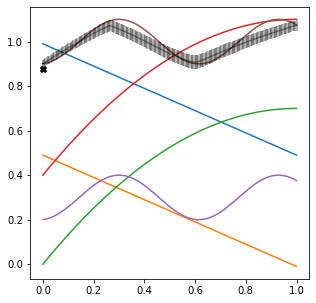

0.90 to 1.07
filling form 400 to 600


(27, 600)

In [36]:

def add_trajectories(starting_pt,current_depth, max_depth, full_graph, new_line):
    if current_depth<=max_depth:
        for i in range(len(params_array)):
            print('-'*current_depth+"Depth %d"%(current_depth))
            print("Starting from %.2f"%starting_pt)
            time_queries = np.zeros((200,4))
            time_queries[:,0] = np.linspace(0,1,200)
            time_queries[:,1] = params_array[i][0] 
            time_queries[:,2] = params_array[i][1] 
            time_queries[:,3] = params_array[i][2] 
            #prevision
            predicted_Ys,predicted_std=predict_model(np.array([np.concatenate(([0.0],[starting_pt]))]),time_queries)
            print("%.2f to %.2f"%(predicted_Ys[0],predicted_Ys[-1]))
            print("filling form %i to %i"%(current_depth*time_queries.shape[0],(current_depth+1)*time_queries.shape[0]))
            #modify line
            new_line[ 0, current_depth*time_queries.shape[0]:(current_depth+1)*time_queries.shape[0] ] = predicted_Ys.T
            #recursive call to further modify
            full_graph=add_trajectories(predicted_Ys[-1,0], current_depth+1, max_depth, full_graph, new_line)
        return full_graph
    else:
        #add line to graph
        full_graph= np.vstack((full_graph, new_line)) 
        return full_graph

full_graph=add_trajectories(start, current_depth=0, max_depth=max_depth, full_graph=full_graph, new_line=np.zeros((1,lengh_time)))
full_graph.shape

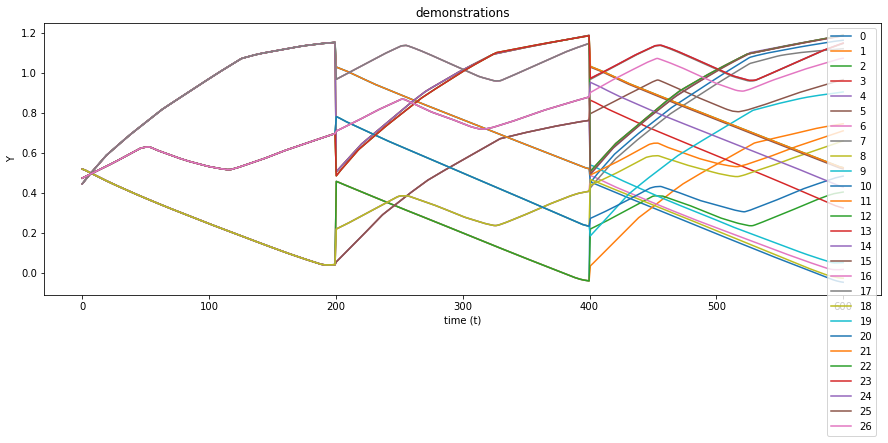

In [37]:
#plot demonstrations
# CONCATENATED
fig_x_size=5*(max_depth+1)
fig = plt.figure(figsize=(fig_x_size,5))
for t in range(full_graph.shape[0]):
    plt.plot(np.linspace(0,lengh_time,lengh_time), full_graph[t], label="%d"%(t) )
plt.title("demonstrations")
plt.ylabel('Y')
plt.xlabel('time (t)')
plt.legend()
plt.show()

## Filter

In [38]:

def remove_sequences_with_large_jumps(arr, threshold):
    # Create an empty list to store sequences that do not exceed the threshold
    valid_sequences = []

    # Iterate over each sequence in the array
    for sequence in arr:
        # Calculate the absolute differences between consecutive elements in the sequence
        diffs = np.abs(np.diff(sequence))

        # Check if none of the differences exceed the threshold
        if not np.any(diffs > threshold):
            valid_sequences.append(sequence)

    # Convert the list of valid sequences back to a NumPy array
    return np.array(valid_sequences)



# Set the threshold for jump detection
threshold = 0.1

# Remove sequences with jumps exceeding the threshold
filtered_graph = remove_sequences_with_large_jumps(full_graph, threshold)

# Print the shapes of the original and filtered arrays
print("Original array shape:", full_graph.shape)
print("Filtered array shape:", filtered_graph.shape)


Original array shape: (27, 600)
Filtered array shape: (5, 600)


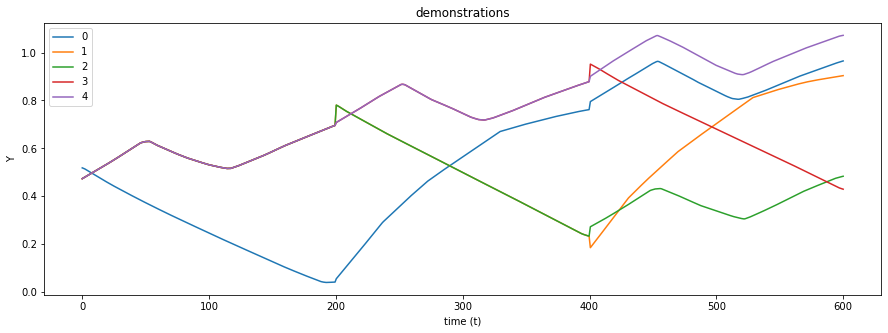

In [39]:
#plot demonstrations
# CONCATENATED
fig_x_size=5*(max_depth+1)
fig = plt.figure(figsize=(fig_x_size,5))
for t in range(filtered_graph.shape[0]):
    plt.plot(np.linspace(0,lengh_time,lengh_time), filtered_graph[t], label="%d"%(t) )
plt.title("demonstrations")
plt.ylabel('Y')
plt.xlabel('time (t)')
plt.legend()
plt.show()